<H2>Analysis of Last.fm Friends and Neigbors</H2>

The analysis here examines data from Last.fm, a music streaming service.  The files imported primarily consist of 2 files:
<li>
Friends--a file of two users ids (anonymous id's, each one a last.fm member).  This is a symmetric relationship, user a in the file is a friend of user b and vice versa.
</li>
<li>
Neighbors-- a file of two user ids.  This is not a symmetric relationship.  User A has a neighbor of B, but user B is not necessarily a neighbor of user A.  The neighbors are people, through an algorith, that last.fm has identified as having similar musical tastes as yourself, and therefore, you might want to explore the music they play to expand your musical horizons.
</li>

The other file imported is annotations.  This lists a user, an item (i.e., musical track) and a tag (i.e., a musical genre the track is classified as).  

The annotations file, was used to filter the original files, some of which had millions of rows.  This was done in the prior script.  Basically the filtering done, was to filter the neighbors and friends files down into only those users who listened to music with these tags:
    * 31	alternative
    * 637	country
    * 636	classic rock
    * 23935	chamber music
    * 23	rap
    * 360	classical
    
This reduced the files to  a "large: size as opposed to a "huge" size.

The analysis in this notebook, is then to examine the centrality of the users in both the friends file and the neighbors file for each of these 6 genres, noting differences in centrality between the genres as well as between the friends and neighbors files.

The original, un-subsetted files were retrieved from here, at the last fm section of this page:
<href>
http://cnets.indiana.edu/resources/data-repository/
</href>

Youtube video describing this project:

<href>
https://www.youtube.com/watch?v=KTOJQIkji0o&feature=youtu.be&hd=1
</href>

First lets import the files we subseted into dataframes:


In [1]:
import pandas as pd

#tags:
# 31	alternative
# 637	country
# 636	classic rock
# 23935	chamber music
# 23	rap
# 360	classical

tags = [31, 637, 636, 23935, 23, 360]

#path = "C:/school/cuny/620/lastfm/"
path = "./"

with open(path  + "annotationsSubset.txt", "r")as f:                   
    dfAnnotations = pd.read_csv(f)      


with open(path  + "friendsSubset.txt", "r") as f:
    dfFriends = pd.read_csv(f)

with open(path  + "neighboursSubset.txt", "r") as f:
    dfNeighbors = pd.read_csv(f)

<B>Make Friends and Neighbors Graph Objects</B>

In this section of code, we create a class G, which holds a musical tag, and Graph object.  We then create graphs for each of the 6 musical classifications we are examining, and make two lists, one of all the graphs of the Friends and one of all the graphs of the neighbors.

In [76]:
import networkx as nx
from enum import Enum
class tags(Enum):
    alternative = 31
    country = 637
    classicRock = 636
    chamberMusic = 23935
    rap = 23
    classical = 360

class G:
    tag = None    
    def __init__(self, tag, graph):
        self.tag = tag
        self.G = graph #nx.Graph()
        

GFriends = []
GNeighbors = []

[GFriends.append(G(tag, nx.Graph())) for tag in tags]
[GNeighbors.append(G(tag, nx.Graph())) for tag in tags]

i=0;    
for tag in tags:    
    for row in dfAnnotations.itertuples():
        if int(row.Tag) == tag.value:
            GFriends[i].G.add_node(int(row.User))
            GNeighbors[i].G.add_node(int(row.User))
    dfAnnTag = dfAnnotations[dfAnnotations.Tag == tag.value]        
    [GFriends[i].G.add_edge(edge[0], edge[1]) for edge in dfFriends[['UserA', 'UserB']].values if edge[0] in dfAnnTag['User']]    
    [GNeighbors[i].G.add_edge(edge[0], edge[1]) for edge in dfNeighbors[['UserA', 'UserB']].values if edge[0] in dfAnnTag['User']]    
    i = i+1                    



<B>Friend's Degrees</B>

Here we loop through all the genres (tags) in the friends graph list, and find the max and min degrees of all the nodes.  Not surprisingly, chamber music has the smallest maximum degree, but there is a wide variation in degree between the genres.  All genres minimum is zero.

In [77]:
columns = ['Tag', 'MaxDegree', 'MaxNode', 'MinDegree', 'MinNode']
dfFDegrees = pd.DataFrame(columns = columns)

for gf in GFriends:
    friendsDegrees = dict(gf.G.degree) 
    df = pd.DataFrame(data = [[gf.tag.name, max(friendsDegrees.values()), max(friendsDegrees, key =friendsDegrees.get),\
                              min(friendsDegrees.values()), min(friendsDegrees, key =friendsDegrees.get)]], \
                     columns = columns)   
    dfFDegrees = dfFDegrees.append(df)

dfFDegrees


,Tag,MaxDegree,MaxNode,MinDegree,MinNode
0,rap,3147.0,7727.0,0.0,65471.0
0,alternative,3375.0,4877.0,0.0,3.0
0,classical,4211.0,432.0,0.0,3.0
0,classicRock,4168.0,1024.0,0.0,262150.0
0,country,2504.0,5470.0,0.0,131289.0
0,chamberMusic,62.0,198709.0,0.0,356360.0


<B>Neighbor's Degrees</B>

Doing the same for for Neighbors, we see that the max degree here doesn't vary much with genre, classic rock has the highest degree, and again chamber music the lowest, though their max is insignificantly diffferent from country and rap in this case.  Again minimum is zero for all the nodes.

In [78]:
dfNDegrees = pd.DataFrame(columns = columns)

for gn in GNeighbors:
    neighborsDegrees = dict(gn.G.degree)
    df = pd.DataFrame(data = [[gn.tag.name, max(neighborsDegrees.values()), max(neighborsDegrees, key =neighborsDegrees.get),\
                              min(neighborsDegrees.values()), min(neighborsDegrees, key =neighborsDegrees.get)]], \
                     columns = columns)   
    dfNDegrees = dfNDegrees.append(df)

dfNDegrees


,Tag,MaxDegree,MaxNode,MinDegree,MinNode
0,rap,63.0,25526.0,0.0,131213.0
0,alternative,82.0,296.0,0.0,524350.0
0,classical,69.0,37012.0,0.0,3.0
0,classicRock,95.0,296.0,0.0,262150.0
0,country,65.0,32386.0,0.0,131289.0
0,chamberMusic,60.0,198709.0,0.0,356360.0


<B>Plot of Friend degrees</B>

Here we plot degrees in bins of 100, and we see that most people fall into a category with few if any friends, meaning most people listen to last.fm and don't bother using the social networking aspect of it.  If we plot the loglog of the degrees we get a more interesting graph and while we obviously see that most people friend a small (or no) people, there are some people with upwards of 1000 last.fm "friends".  Also we see that classical listeners seem to friend a little more often than others, with a smaller set of users the friend more than rap or country genres.

Also it apears that chamber music may not have enough people for people to meaningfully "friend" up.

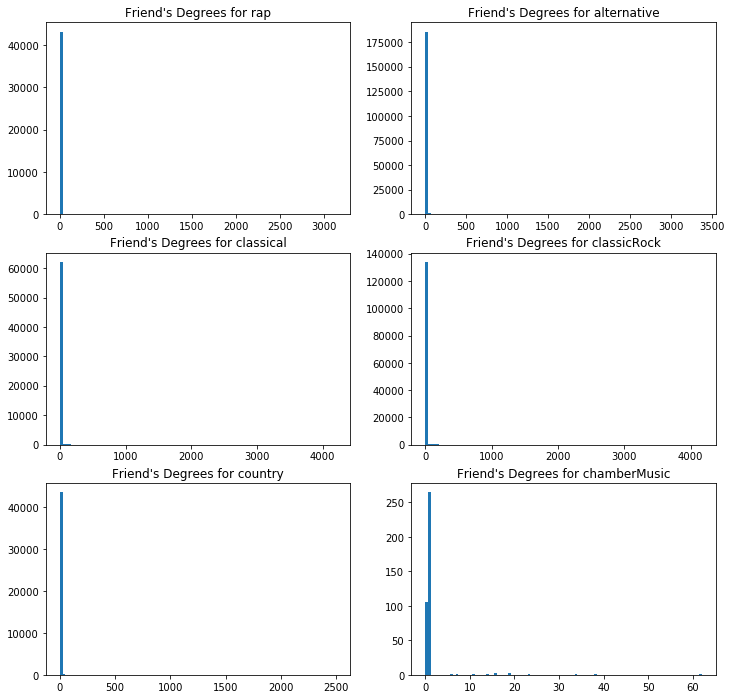

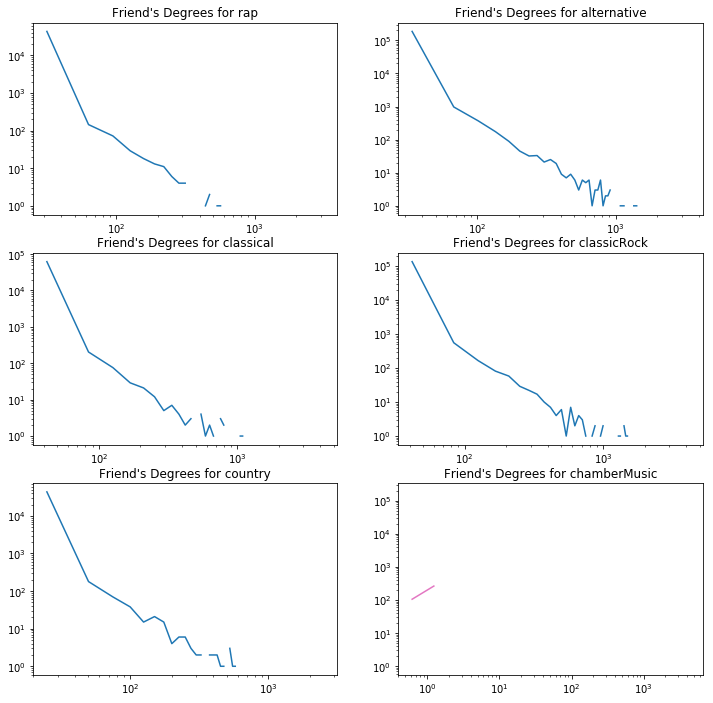

In [79]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]

f, ax = plt.subplots(3,2)
x=0
for i in range(3):        
    for j in range(2):        
        friendsDegrees = dict(GFriends[x].G.degree)            
        ax[i,j].hist(friendsDegrees.values(), 100) 
        ax[i,j].set_title("Friend's Degrees for " + GFriends[x].tag.name)
        x = x+1 
plt.show()


f, ax = plt.subplots(3,2)
x=0
for i in range(3):        
    for j in range(2):        
        friendsDegrees = dict(GFriends[x].G.degree)    
        h= plt.hist(friendsDegrees.values(), 100) 
        ax[i,j].loglog(h[1][1:], h[0])    
        ax[i,j].set_title("Friend's Degrees for " + GFriends[x].tag.name)
        x = x+1 
plt.show()

<B>Plot of Neighbor Degrees</B>

Here we do the same plots except for neighbors and reduce bin size to 10.  Again we see that most people fall into a category with few neighbors.  Interestingly there is a spike for all graphs of people who have approximately 60 neighbors.



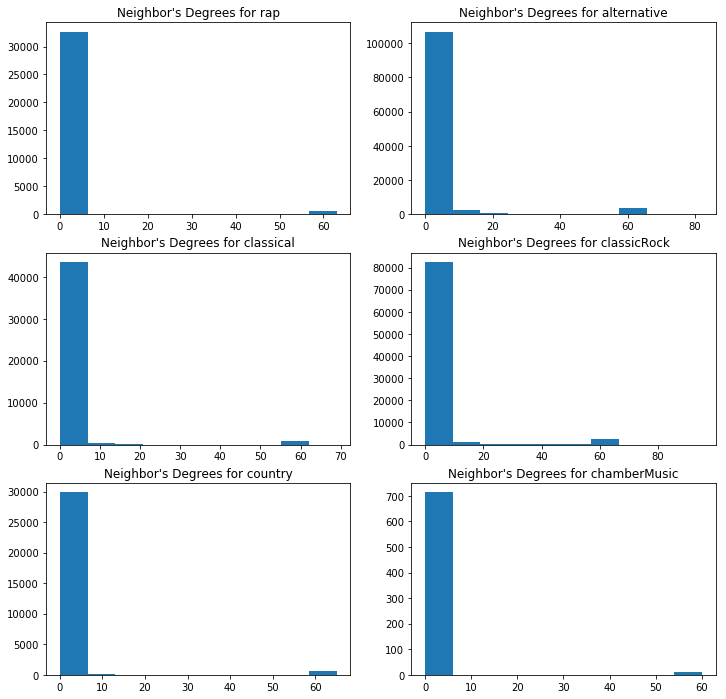

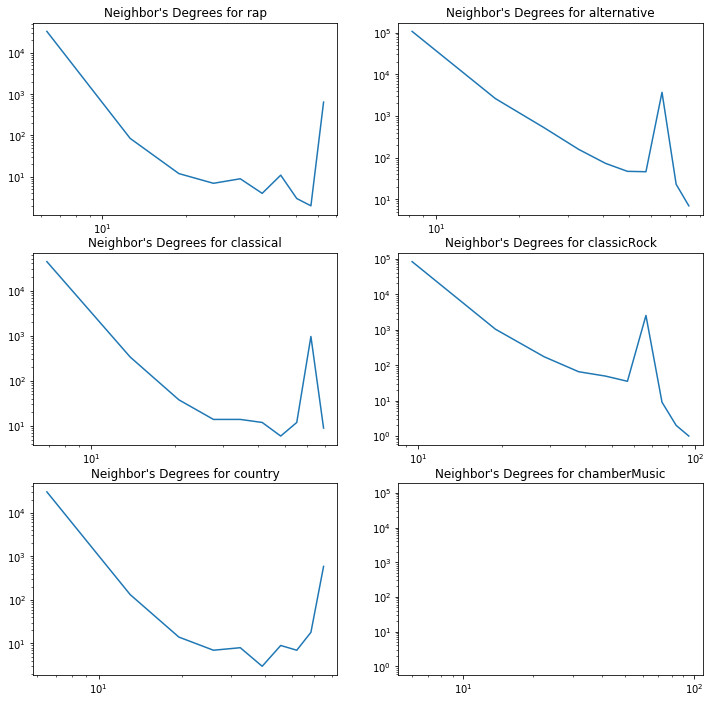

In [80]:
plt.rcParams['figure.figsize'] = [12, 12]

f, ax = plt.subplots(3,2)
x=0
for i in range(3):        
    for j in range(2):        
        neighborsDegrees = dict(GNeighbors[x].G.degree)            
        ax[i,j].hist(neighborsDegrees.values(), 10) 
        ax[i,j].set_title("Neighbor's Degrees for " + GNeighbors[x].tag.name)
        x = x+1 
plt.show()


f, ax = plt.subplots(3,2)
x=0
for i in range(3):        
    for j in range(2):        
        neighborsDegrees = dict(GNeighbors[x].G.degree)    
        h= plt.hist(neighborsDegrees.values(), 10) 
        ax[i,j].loglog(h[1][1:], h[0])    
        ax[i,j].set_title("Neighbor's Degrees for " + GNeighbors[x].tag.name)
        x = x+1 
plt.show()




<B>Pruning for Eigen Values</B>

The graphs created above are too large to reasonably be able to run the function eigenvector_centrality (the function would fail saying it couldn't complete with the max iteration set at 100 depth, and considering the lenght of time it took before it failed, it seemed wiser to do some pruning rather than tyring to make the max iteraion a higher value.)

So here, we prune all nodes with degrees less than or equal to 2 for friends and less than or equal to 6 for neighbors.

In [81]:
def prune(GArray, pruneLevel):
    GSmall = []
    for bigG in GArray:
        smallG = bigG.G.copy()
        degree = nx.degree(smallG)
        nodes = bigG.G.nodes()
        for node in nodes():
            if degree[node] <= pruneLevel: smallG.remove_node(node)
        GSmall.append(G(bigG.tag, smallG))
    return GSmall
  
GFSmall = prune(GFriends, 2)
GNSmall = prune(GNeighbors, 6)

print("Number of nodes in the new smaller friend's network graph ")
for gf in GFSmall:
    print(len(gf.G.nodes()))
    
print("Number of nodes in the new smaller neighbor's network graph ")    
for gn in GNSmall:
    print(len(gn.G.nodes()))

Number of nodes in the new smaller friend's network graph 
1024
16156
2000
9037
1073
9
Number of nodes in the new smaller neighbor's network graph 
624
9364
1304
5422
730
10


In [82]:
for gf in GFSmall:
    for key in gf.G.nodes.keys():
        try:
            gf.G.nodes[key]['Item'] = dfAnnotations[dfAnnotations['User'] == key]['Item']
            gf.G.nodes[key]['Tag'] = dfAnnotations[dfAnnotations['User'] == key]['Tag']        
        except:
            pass

for gn in GNSmall:
    for key in gn.G.nodes.keys():
        try:
            gn.G.nodes[key]['Item'] = dfAnnotations[dfAnnotations['User'] == key]['Item']
            gn.G.nodes[key]['Tag'] = dfAnnotations[dfAnnotations['User'] == key]['Tag']        
        except:
            pass
        

    
    
    

Now that we have pruned the graphs, we can create an array of the eigen values.

In [83]:
GFEigen = {}
for gf in GFSmall:
    GFEigen[gf.tag] = (nx.eigenvector_centrality(gf.G))
    
GNEigen = {}
for gn in GNSmall:    
    GNEigen[gn.tag] =(nx.eigenvector_centrality(gn.G))



<B>Eigen Values of "Friend" Nodes </B>
Here we list the top 5 friend nodes by Eigen Value.  Here it is interesting to note that for each of the categories, save for chamber music, there is one "super" user with an Eigen value of about 0.50 or higher, and after that the centrality of other users falls off very quickly.  Chamber music really didn't have enough data to analyze.

In [84]:
GFEigenSorted = {}
for key in GFEigen.keys():    
    GFEigenSorted[key] = sorted(GFEigen[key].iteritems(), key=lambda (k,v): (v,k), reverse=True)
    
GNEigenSorted = {}
for key in GNEigen.keys():    
    GNEigenSorted[key] = sorted(GNEigen[key].iteritems(), key=lambda (k,v): (v,k), reverse=True)    
    
rows_list = []
for key in GFEigenSorted.keys(): 
    for i in range(5):        
        row = (key.name, GFEigenSorted[key][i][0],  GFEigenSorted[key][i][1])
        rows_list.append(row)
dfF = pd.DataFrame(rows_list, columns = ['Tag', 'Node', 'Eigen Value'])          
    
dfF    

,Tag,Node,Eigen Value
0,classical,432,0.552953
1,classical,8779,0.254917
2,classical,8797,0.242242
3,classical,20410,0.212790
4,classical,463,0.138055
5,chamberMusic,270939,0.333333
6,chamberMusic,247054,0.333333
7,chamberMusic,208626,0.333333
8,chamberMusic,198881,0.333333
9,chamberMusic,198868,0.333333


<B>Eigen Values of "Neighbor" Nodes </B>
Here we list the top 5 neighbor nodes by Eigen Value.  Unlike the friend nodes, there was no "super" node with an exceptionally high Eigen Centrality value.

In [85]:
rows_list = []
for key in GNEigenSorted.keys(): 
    for i in range(5):        
        row = (key.name, GNEigenSorted[key][i][0],  GNEigenSorted[key][i][1])
        rows_list.append(row)
dfF = pd.DataFrame(rows_list, columns = ['Tag', 'Node', 'Eigen Value'])          
    
dfF

,Tag,Node,Eigen Value
0,classical,151818,0.196557
1,classical,41100,0.177221
2,classical,206108,0.175309
3,classical,296,0.174244
4,classical,36601,0.161690
5,chamberMusic,270939,0.316228
6,chamberMusic,247054,0.316228
7,chamberMusic,198881,0.316228
8,chamberMusic,198868,0.316228
9,chamberMusic,198854,0.316228


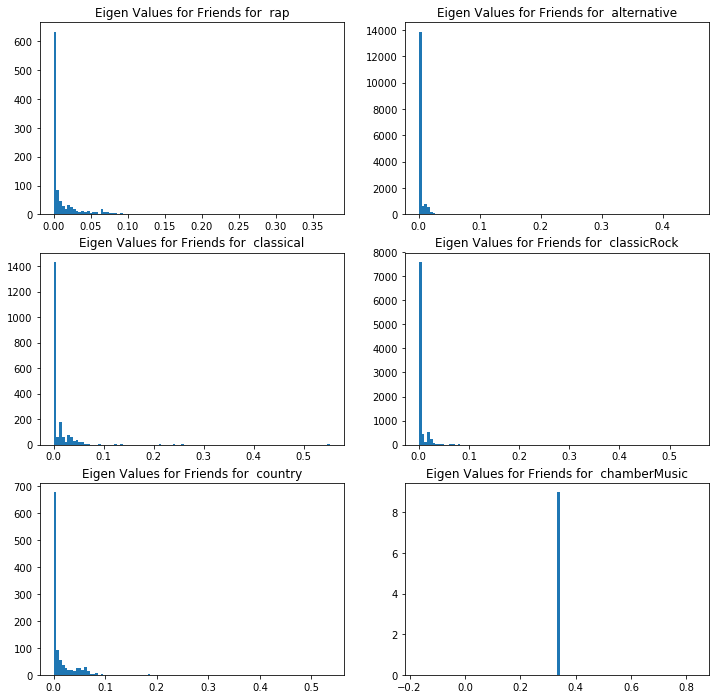

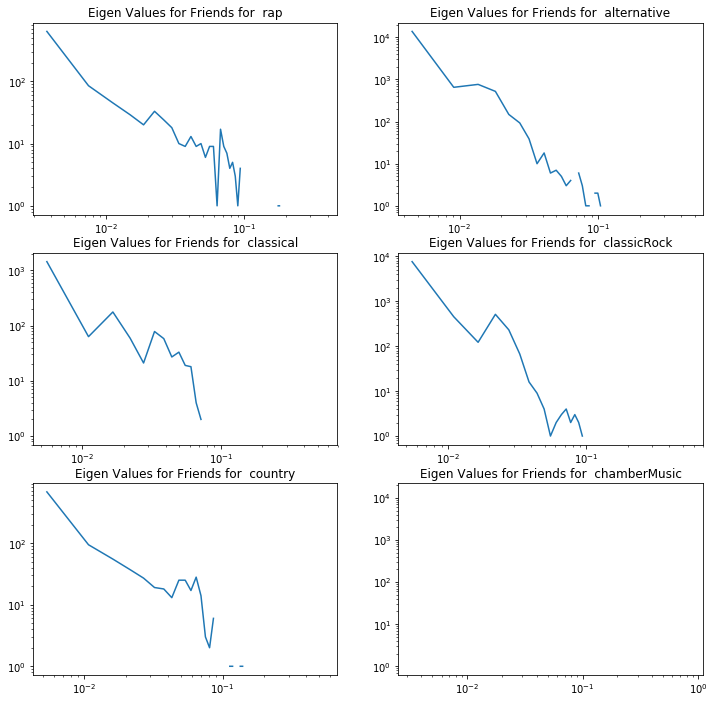

In [86]:
plt.rcParams['figure.figsize'] = [12, 12]


f, ax = plt.subplots(3,2)
tagList = []
[tagList.append(tag) for tag in tags];
x=0
for i in range(3):        
    for j in range(2):        
        eigenVals = GFEigen[tagList[x]]
        ax[i,j].hist(eigenVals.values(), 100) 
        ax[i,j].set_title("Eigen Values for Friends for  " + tagList[x].name)
        x = x+1 
plt.show()

f, ax = plt.subplots(3,2)
x=0
for i in range(3):        
    for j in range(2):        
        eigenVals = GFEigen[tagList[x]]   
        h= plt.hist(eigenVals.values(), 100)           
        ax[i,j].loglog(h[1][1:], h[0])    
        ax[i,j].set_title("Eigen Values for Friends for  " + tagList[x].name)
        x = x+1 
plt.show()

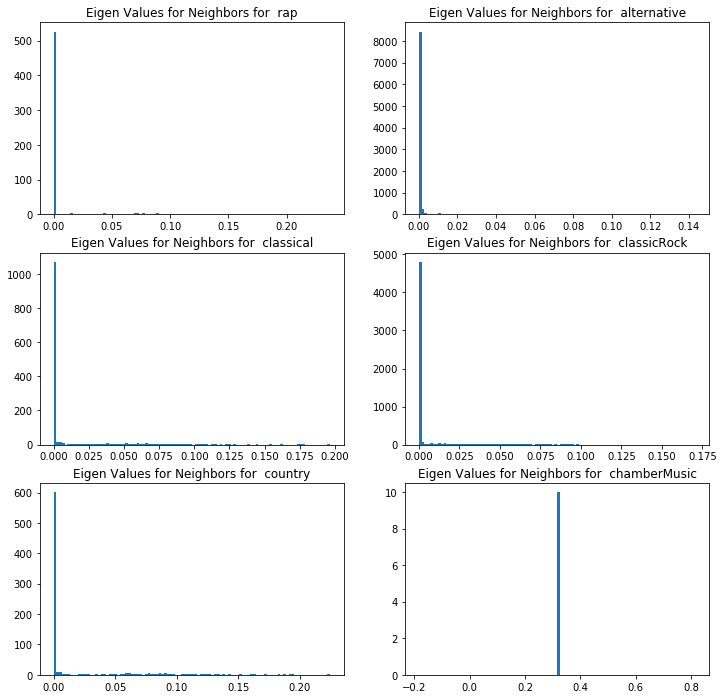

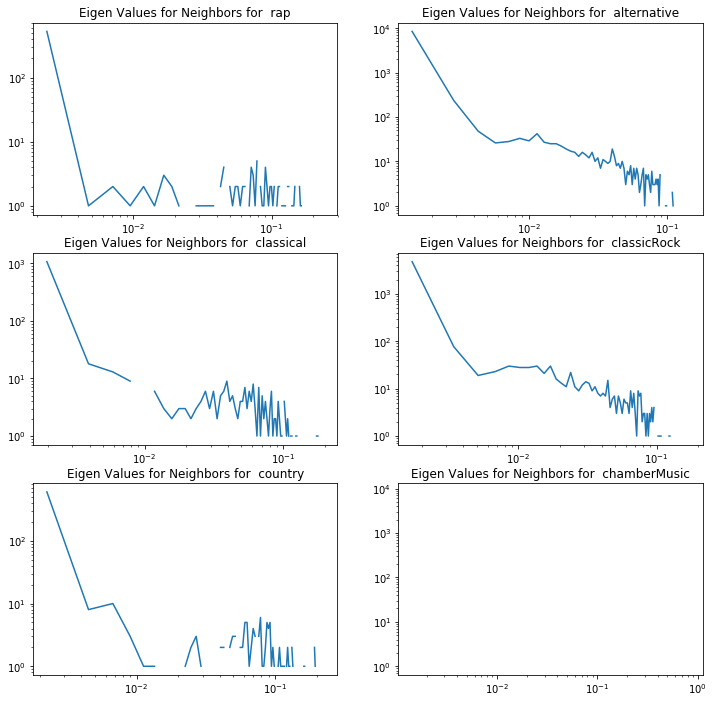

In [87]:
plt.rcParams['figure.figsize'] = [12, 12]


f, ax = plt.subplots(3,2)
tagList = []
[tagList.append(tag) for tag in tags];
x=0
for i in range(3):        
    for j in range(2):        
        eigenVals = GNEigen[tagList[x]]
        ax[i,j].hist(eigenVals.values(), 100) 
        ax[i,j].set_title("Eigen Values for Neighbors for  " + tagList[x].name)
        x = x+1 
plt.show()

f, ax = plt.subplots(3,2)
x=0
for i in range(3):        
    for j in range(2):        
        eigenVals = GNEigen[tagList[x]]   
        h= plt.hist(eigenVals.values(), 100)           
        ax[i,j].loglog(h[1][1:], h[0])    
        ax[i,j].set_title("Eigen Values for Neighbors for  " + tagList[x].name)
        x = x+1 
plt.show()